In [1]:
import inspect
from time import sleep

from CybORG import CybORG
from CybORG.Agents import B_lineAgent, BlueReactRestoreAgent, BlueReactRemoveAgent, SleepAgent, DroneRedAgent, \
    RandomAgent, BaseAgent, RedMeanderAgent
from CybORG.Agents.SimpleAgents.DroneRedAgent import DroneRedAgent
from CybORG.Simulator.Scenarios import FileReaderScenarioGenerator, DroneSwarmScenarioGenerator
import pygame
from CybORG.Simulator.Actions.ConcreteActions.RemoveOtherSessions import RemoveOtherSessions
from CybORG.Simulator.Actions.ConcreteActions.ExploitActions.RetakeControl import RetakeControl
import random
from pprint import pprint
from CybORG.Shared.Results import Results
from CybORG.Agents.Wrappers import PettingZooParallelWrapper

/Users/myong/Library/Caches/pypoetry/virtualenvs/cyborg-b_S6pbUY-py3.9/lib/python3.9/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)


This sets up the scenario with the number of required drones using `num_drones`. It also sets up the default read agent and the number of red agents already running sessions on the drones.

The methods print out some information about the red, blue and green teams.

In [7]:
num_drones=5
sg = DroneSwarmScenarioGenerator(num_drones=num_drones, default_red_agent=DroneRedAgent, starting_num_red=1)
cyborg = CybORG(scenario_generator=sg, environment='sim',seed=0)
wrapped_cyborg = PettingZooParallelWrapper(env=cyborg)
observations = wrapped_cyborg.reset()

def get_teams(verbose=True)->dict:
  teams = cyborg.environment_controller.team
  if verbose:
    print("{} Teams: {}".format(len(teams.keys()), set(teams.keys())))
  return teams

def get_members(team:str, verbose:bool=True)->list:
  teams = cyborg.environment_controller.team
  if verbose: 
    print("\n{} Members: {}".format(team, teams[team]))
  return teams[team]

def get_actions(agent, verbose:bool=True)->list:
  agent_action_space = cyborg.get_action_space(agent)['action']
  filtered_action_space = {key: value for key, value in agent_action_space.items() if value}
  action_classes = list(filtered_action_space.keys())
  action_names = [action.__name__ for action in action_classes]
  if verbose:
    print("{} ({}) action space: {}".format(agent, len(action_names), action_names))
  return action_names

def get_wrapped_actions(agent, verbose:bool=True)->list:
  action_names = wrapped_cyborg.get_action_space(agent)
  if verbose:
    print("{} ({}) action space: {}".format(agent, len(action_names), action_names))
  return action_names

def print_players()->tuple[list[str],list[str]]:
  teams = get_teams()
  for team in teams.keys():
    members = get_members(team)
    for member in members:
      get_wrapped_actions(member)  

blues = get_members('Blue', verbose=False)
reds = get_members('Red', verbose=False)
greens = get_members('Green', verbose=False)

print_players()

# get_players()

red_observations = cyborg.environment_controller.get_last_observation(reds[0]).get_dict()
# print(red_observations)
blue_observations = cyborg.environment_controller.get_last_observation(blues[0]).get_dict()
assert(set(red_observations.keys())==set(blue_observations.keys()))

3 Teams: {'Blue', 'Red', 'Green'}

Red Members: ['red_agent_0', 'red_agent_1', 'red_agent_2', 'red_agent_3', 'red_agent_4', 'Red_Trojan']
red_agent_0 (26) action space: ['ExploitDroneVulnerability drone_0', 'ExploitDroneVulnerability drone_1', 'ExploitDroneVulnerability drone_2', 'ExploitDroneVulnerability drone_3', 'ExploitDroneVulnerability drone_4', 'SeizeControl drone_0', 'SeizeControl drone_1', 'SeizeControl drone_2', 'SeizeControl drone_3', 'SeizeControl drone_4', 'FloodBandwidth drone_0', 'FloodBandwidth drone_1', 'FloodBandwidth drone_2', 'FloodBandwidth drone_3', 'FloodBandwidth drone_4', 'BlockTraffic drone_0', 'BlockTraffic drone_1', 'BlockTraffic drone_2', 'BlockTraffic drone_3', 'BlockTraffic drone_4', 'AllowTraffic drone_0', 'AllowTraffic drone_1', 'AllowTraffic drone_2', 'AllowTraffic drone_3', 'AllowTraffic drone_4', 'Sleep']
red_agent_1 (26) action space: ['ExploitDroneVulnerability drone_0', 'ExploitDroneVulnerability drone_1', 'ExploitDroneVulnerability drone_2', 'Ex

This is a method that shows the drones; specifically the agents that are running sessions on the drones.

In [10]:
def get_drone_sessions(agents:list[str], verbose=True)->dict[str, str]:
  my_drones = {}
  for a in agents:
    obs = cyborg.get_observation(a)
    obs_about_drones = { k : obs[k]
                 for k in obs
                 if "drone_" in k}
    for d, o in obs_about_drones.items():
      if 'Sessions' in o:
        # pprint(o['Sessions'])
      # [{'Agent': 'blue_agent_0',
      # 'ID': 0,
      # 'Type': <SessionType.BLUE_DRONE_SESSION: 13>,
      # 'Username': 'root'}]
        for s in o['Sessions']:
          # print(s['Agent'])
          if d in my_drones:
            if (isinstance(my_drones[d], list)):
              my_drones[d].append(a)
            else:
              my_drones[d] = [a]
          else:
            my_drones[d] = [a]
  if (verbose):
    for drone, owner in my_drones.items():
      pprint("{} running sessions by {}".format(drone, owner))
  return my_drones

drone_sessions = get_drone_sessions(blues+reds+greens, verbose=True)
# pprint(cyborg.get_observation('red_agent_2'))

"drone_0 running sessions by ['blue_agent_0', 'green_agent_0']"
"drone_1 running sessions by ['blue_agent_1', 'green_agent_1']"
"drone_3 running sessions by ['blue_agent_3', 'green_agent_3']"
"drone_4 running sessions by ['blue_agent_4', 'green_agent_4']"
"drone_2 running sessions by ['red_agent_2', 'green_agent_2']"


This cell sets up the following:

1. A method for pulling a team's last set of actions
2. A method for getting a set of actions for the blue agents, and taking a single step in the environment by running the set of agents. This also prints the outcomes of taking this set of actions.

First we set up a random blue agent for each blue agent in the scenario. Then we call run each step 30 times. At each 10th step, we print out the sessions running by agents by each of the drones.

In [4]:
from CybORG.Evaluation.submission.RandomAgent import RandomAgent

def get_team_last_actions(team:str, verbose=True)->dict[str, str]:
    team_actions = {}
    members = get_members(team=team, verbose=False)
    for member in members:
        action = cyborg.get_last_action(member)
        if verbose:
            print("{}: {}".format(member, action))
        team_actions[member]=action
    return team_actions

def one_step(observations:dict, agents:dict[str, RandomAgent], verbose:bool=True)->tuple[dict, dict, dict, dict]:
    actions_taken = {}
    action_spaces = wrapped_cyborg.action_spaces    
    action_index = {
        agent_name: agent.get_action(
            observations[agent_name], 
            action_spaces[agent_name]
        ) 
        for agent_name, agent in agents.items() 
        if agent_name in wrapped_cyborg.agents
    }
    obs, rew, done, info = wrapped_cyborg.step(action_index)

    for k, v in action_index.items():
        actions = get_wrapped_actions(k, False)
        action_taken = str(cyborg.get_last_action(k))
        actions_taken[k]=action_taken
        assert(action_taken in actions[v])
        if (verbose):
            print("{} took action: {}".format(k,actions[v]))
            print("Reward: {}".format(rew[k]))
            if (k in info):
                print("Info: {}".format(info[k]))
            print("Observations: {}".format(cyborg.get_observation(k)))
            print("Done: {}\n".format(done[k]))
    return (obs, rew, done, info)

blue_agents = {f"{agent}": RandomAgent() for agent in blues}
observations = wrapped_cyborg.reset()
num_steps = 30
for s in range(num_steps):
    report = False
    if (s%10==0):
        print("\nAt t = {}".format(s))
        get_drone_sessions(blues+reds, verbose=True)
    obs, rew, done, info = one_step(observations, agents=blue_agents,verbose=False)


At t = 0
"drone_1 running sessions by ['blue_agent_1']"
"drone_2 running sessions by ['blue_agent_2']"
"drone_3 running sessions by ['blue_agent_3']"
"drone_4 running sessions by ['blue_agent_4']"
"drone_0 running sessions by ['red_agent_0']"

At t = 10
"drone_1 running sessions by ['blue_agent_1']"
"drone_2 running sessions by ['blue_agent_2']"
"drone_4 running sessions by ['blue_agent_4']"
"drone_0 running sessions by ['red_agent_0']"
"drone_3 running sessions by ['red_agent_3']"

At t = 20
"drone_1 running sessions by ['blue_agent_1']"
"drone_2 running sessions by ['blue_agent_2']"
"drone_4 running sessions by ['blue_agent_4']"
"drone_0 running sessions by ['red_agent_0', 'red_agent_0']"
"drone_3 running sessions by ['red_agent_3']"


These are methods that find drones hosting red sessions, that are connected to an agent/drone. 

`find_connected_red_drones` in particular finds all connections using `show_connections` and finds all red sessions using `get_drone_sessions`. It intersects these to find connected drones running red sessions.

`recommend_an_action` takes the list of connected reds and looks on the list of available actions to return a list of actions with the names of the connected reds.

In [11]:
def show_connections(agent:str, verbose=True)->list[str]:
  connections = wrapped_cyborg.env.environment_controller.get_connected_agents(agent)
  connections_no_self = [c
                         for c in connections
                         if c not in agent]
  if verbose:
    print("{} is connected to {}".format(agent, connections_no_self))
  return connections_no_self 

def find_connected_red_drones(agent:str, verbose=True)->list[str]:
  connected_red_drones = []
  connections = show_connections(agent, verbose=False)
  red_drones = get_drone_sessions(reds, verbose=False)
  for drone, agents in red_drones.items():
    connected_red_agents = set(connections).intersection(agents)
    if(len(connected_red_agents)>0):
      connected_red_drones.append(drone)
  if verbose:
    print("{} is connected to {} red drones: {}".format(agent, 
                                                          len(connected_red_agents), 
                                                          connected_red_drones))
  return connected_red_drones

def recommend_an_action(agent:str, verbose=True)->list[str]:
  connected_red_drones = find_connected_red_drones(agent=agent, verbose=False)
  actions = get_wrapped_actions(agent, verbose=False)
  relevant_actions = []
  for drone_name in connected_red_drones:
    for action in actions:
      if drone_name in action:
        relevant_actions.append(action)
  if verbose:
    if (len(relevant_actions)>0):
      print("{} is connected to Red's {}.\nPlausible actions are {}".format(agent, connected_red_drones, relevant_actions))
  return relevant_actions

# recommend_an_action(blues[0])


In [26]:
from CybORG.Simulator.Actions import *

def get_team_last_actions(team:str, verbose=True)->list:
    team_actions = []
    members = get_members(team=team, verbose=False)
    for member in members:
        # action = cyborg.get_last_action(member)
        action = wrapped_cyborg.get_last_action(agent=member)
        if verbose:
            print("{}: {}".format(member, action))
        team_actions.append(action)
    return team_actions

def random_step(agents:list, verbose:bool=True)->tuple[dict, dict, dict, dict, dict]:
    action_index={}
    action_names={}
    actions_taken = {}
    for a in agents:
        if a in wrapped_cyborg.agents:
            actions = get_wrapped_actions(agent=a, verbose=False)
            action_index[a] = random.choice(range(0,len(actions)-1))
            action_names[a] = actions[action_index[a]]
    print(action_names)
    obs, reward, done, info = wrapped_cyborg.step(action_index)
    
    for k, v in action_index.items():
        actions = get_wrapped_actions(k, False)
        action_taken = str(cyborg.get_last_action(k))
        actions_taken[k]=action_taken
        assert(action_taken in actions[v])
        if verbose:
            print("{} took action: {}".format(k,actions[v]))
            if k in rew:
                print("Reward: {}".format(rew[k]))
            if (k in info):
                print("Info: {}".format(info[k]))
            print("Observations: {}".format(cyborg.get_observation(k)))
            print("Done: {}\n".format(done[k]))

    return obs, reward, done, info
    #     clock.tick(frame_rate)
    
def human_step(agents:list, verbose:bool=True)->tuple[dict, dict, dict, dict, dict]:
    action_index={}
    action_names={}
    actions_taken = {}
    for a in agents:        
        if a in wrapped_cyborg.agents:
            actions = get_wrapped_actions(agent=a, verbose=False)
            plausible_actions = recommend_an_action(agent=a,verbose=True)
            plausible_actions.append("Sleep")
            for choice in plausible_actions:
                print("Press {} for {}".format(actions.index(choice), choice))
            choice = input("Make your choice [0-{}]. q to quit.".format(len(actions)-1))
            choice_int = int(choice)
            if not isinstance(choice_int, int):
                break
            action_index[a] = choice_int
            action_names[a] = actions[choice_int]

    # print(action_index)
    obs, reward, done, info = wrapped_cyborg.step(action_index)
    
    for k, v in action_index.items():
        actions = get_wrapped_actions(k, False)
        action_taken = str(cyborg.get_last_action(k))
        actions_taken[k]=action_taken
        assert(action_taken in actions[v])
        if verbose:
            print("{} took action: {}".format(k,actions[v]))
            if (k in reward):
                print("Reward: {}".format(reward[k]))
            if (k in info):
                print("Info: {}".format(info[k]))
            print("Observations: {}".format(cyborg.get_observation(k)))
            print("Done: {}\n".format(done[k]))
        
    return (obs, reward, done, info)

wrapped_cyborg.reset()
# get_drone_sessions(blues+reds+greens, True)
obs, reward, done, info = random_step(blues,verbose=False)
# get_drone_sessions(blues+reds+greens, True)
# obs, reward, done, info = random_step(blues,verbose=True)
get_team_last_actions(team="Blue", verbose=True)
get_team_last_actions(team="Green", verbose=True)
get_team_last_actions(team="Red", verbose=True)
# get_my_drones(blues+reds, verbose=True)

{'blue_agent_0': 'BlockTraffic drone_3', 'blue_agent_2': 'BlockTraffic drone_1', 'blue_agent_3': 'BlockTraffic drone_1', 'blue_agent_4': 'BlockTraffic drone_2'}
blue_agent_0: BlockTraffic
blue_agent_1: Sleep
blue_agent_2: BlockTraffic
blue_agent_3: BlockTraffic
blue_agent_4: BlockTraffic
green_agent_0: SendData
green_agent_1: SendData
green_agent_2: SendData
green_agent_3: SendData
green_agent_4: SendData
red_agent_0: InvalidAction
red_agent_1: ExploitDroneVulnerability 10.0.200.2
red_agent_2: InvalidAction
red_agent_3: InvalidAction
red_agent_4: InvalidAction
Red_Trojan: Sleep


/Users/myong/Library/Caches/pypoetry/virtualenvs/cyborg-b_S6pbUY-py3.9/lib/python3.9/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


[InvalidAction,
 ExploitDroneVulnerability 10.0.200.2,
 InvalidAction,
 InvalidAction,
 InvalidAction,
 Sleep]

In [64]:
def get_drone_position_by_observation(agent:str, verbose = True)->dict[str, list[float]]:
  # print(agent)
  observations = cyborg.get_observation(agent)
  
  # print(observations)
  positions = {}
  for k,v in observations.items():
    if "drone" in k:
      if 'position' in v['System info']:
        positions[k] = [int(p) for p in v['System info']['position']]
  if verbose:
    for k,v in positions.items():
      print("Agent {} thinks that {} is at [{},{}]".format(agent, k, v[0], v[1]) )
  return positions   

def get_all_drones_positions_by_observation(verbose=True)->dict[str, list[int, int]]:
    positions = {}
    for a in blues+reds:
        p = get_drone_position_by_observation(a, verbose=True)
        for k, v in p.items():
            if k in positions:
                if verbose:
                    if positions[k][0]!=v[0] or positions[k][1]!=v[1]:
                        print("{} is either at ({}{}) or ({}{})".format(k, positions[k][0], positions[k][1], v[0],v[1]))
            else:
                positions[k]=v
    if verbose:
        for k, v in positions.items():
            print("{} is at ({},{})".format(k,v[0], v[1]))
    return positions

def get_all_drones_positions(verbose=True)->dict[str, list[int, int]]:
    positions = {}
    ground_truth = cyborg.get_agent_state('True')
    drones = [d for d in ground_truth if 'drone' in d]
    for drone in drones:
        if 'System info' in ground_truth[drone].keys():
            sys_info = ground_truth[drone]['System info']
            if 'position' in sys_info:
                positions[drone] = [int(p) for p in sys_info['position']]
    if verbose:
        for k, v in positions.items():
            print("{} is at ({},{})".format(k,v[0], v[1]))
    return positions  
    
get_all_drones_positions()

drone_0 is at (28,25)
drone_1 is at (57,88)
drone_2 is at (6,65)
drone_3 is at (39,6)
drone_4 is at (40,73)


{'drone_0': [28, 25],
 'drone_1': [57, 88],
 'drone_2': [6, 65],
 'drone_3': [39, 6],
 'drone_4': [40, 73]}

In [63]:
# print(wrapped_cyborg.env.environment_controller.get_connected_agents(reds[0]))
# pprint("Blue: \n{}".format(cyborg.get_agent_state("blue_agent_1")))
# pprint(cyborg.get_agent_state("blue_agent_0"))
# cyborg.get_observation("red_agent_0")
# wrapped_cyborg.get_action_space("red_agent_0")
# p = get_drone_position("blue_agent_0", verbose=True)
# print("Red: {}".format(cyborg.get_agent_state("red_agent_1")))

# def get_drone_position(agent:str, verbose = True)->dict[str, list[float]]:
#   # print(agent)
#   observations = cyborg.get_observation(agent)
  
#   # print(observations)
#   positions = {}
#   for k,v in observations.items():
#     if "drone" in k:
#       if 'position' in v['System info']:
#         positions[k] = [int(p) for p in v['System info']['position']]
#   if verbose:
#     for k,v in positions.items():
#       print("Agent {} thinks that {} is at [{},{}]".format(agent, k, v[0], v[1]) )
#   return positions   

# def get_all_drones_positions(verbose=True)->dict[str, list[int, int]]:
#     positions = {}
#     for a in blues+reds:
#         p = get_drone_position(a, verbose=True)
#         for k, v in p.items():
#             if k in positions:
#                 if verbose:
#                     if positions[k][0]!=v[0] or positions[k][1]!=v[1]:
#                         print("{} is either at ({}{}) or ({}{})".format(k, positions[k][0], positions[k][1], v[0],v[1]))
#             else:
#                 positions[k]=v
#     if verbose:
#         for k, v in positions.items():
#             print("{} is at ({},{})".format(k,v[0], v[1]))
#     return positions
            
positions = get_all_drones_positions(verbose=False)



['drone_0', 'drone_1', 'drone_2', 'drone_3', 'drone_4']
[28.29436376 25.92944888]
[57.96226139 88.99068045]
[ 6.9280704  65.03053207]
[39.30158334  6.99257166]
[40.30076453 73.22023269]


Agent blue_agent_0 thinks that drone_0 is at [42,51]
Agent blue_agent_1 thinks that drone_1 is at [4,97]
Agent blue_agent_1 thinks that drone_4 is at [34,96]
Agent blue_agent_3 thinks that drone_3 is at [94,50]
Agent blue_agent_4 thinks that drone_4 is at [34,96]
Agent blue_agent_4 thinks that drone_1 is at [4,97]
Agent red_agent_2 thinks that drone_2 is at [62,1]


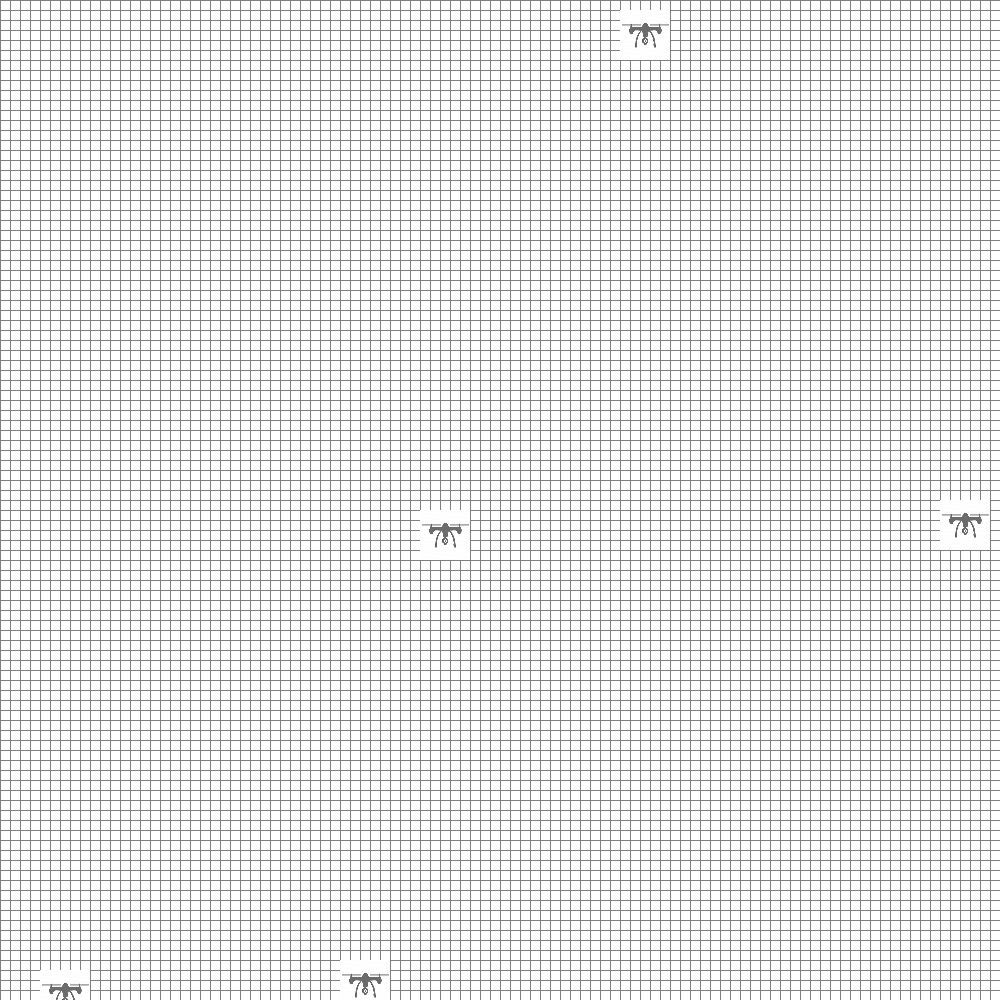

In [38]:
from PIL import Image, ImageDraw

image_height = 1000
image_width = 1000
num_cols = 100
num_rows = 100
col_size = int((image_width) / num_cols)
row_size = int((image_height) / num_rows)

def draw_grid()->Image:
  image = Image.new(mode='L', size=(image_height, image_width), color=255)
  # Draw some lines
  draw = ImageDraw.Draw(image)
  y_start = 0
  y_end = image.height
  x_start = 0
  x_end = image.width

  for x in range(0, image.width, col_size):
      line = ((x, x_start), (x, x_end))
      draw.line(line, fill=128)

  for y in range(0, image.height, row_size):
      line = ((y_start, y), (y_end,y))
      draw.line(line, fill=128)

  del draw
  return image

def get_position_from_grid(background:Image, grid_x:float, grid_y:float)->tuple:
      step_size_col = int(background.width / num_cols)
      step_size_row = int(background.height / num_rows)
      return(grid_x*step_size_col, grid_y*step_size_row)

def draw_drone(background:Image, grid_x:float, grid_y:float)->Image:
    drone_image = Image.open("blue_drone.png")
    drone_width = col_size
    drone_height = row_size
    drone_resized = drone_image.resize((drone_width*3, drone_height*3))
    drone_position_on_screen = get_position_from_grid(background=background, grid_x=grid_x, grid_y=grid_y)
    background.paste(drone_resized, drone_position_on_screen)
    return background

def draw_drones(background:Image, positions:dict)->Image: 
  for k, v in positions.items():
    # print("Drawing {}: [{},{}]".format(k, v[0], v[1]))
    background = draw_drone(background=background, grid_x=v[0], grid_y=v[1])
  return background

# def draw_drones(background:Image, positions:dict)->Image:
#   for k, v in positions.items():
#     draw_drone(background, v[0], v[1])
#   return background

# def get_connected_drones(agent:str)->list: 
#     connected_agents = cyborg.environment_controller.get_connected_agents(agent=agent)
#     connected_drones = []
#     for a in connected_agents:
#       if agent not in a:
#         connected_drones.append(get_drone_name(agent=a))
#     return list(set(connected_drones))

def get_drone_name(agent:str):
   # blue_agent_0
  index = agent.find("_agent_")
  # drone_3
  drone_name = "drone"+agent[index+len("_agent"):]
  return drone_name
   
def draw_connections(background:Image, agent:str):
  #  print(cyborg.environment_controller.get_connected_agents(blues[0]))
  def draw_connection(background: Image, d1:tuple, d2:tuple)->Image:
    # Draw a line between the two points
    draw = ImageDraw.Draw(background)
    draw.line(xy=[d1, d2], fill="black", width=2)
    return background
  
  connected_drones = get_connected_drones(agent)
  
  agent_drone = get_drone_name(agent)
  agent_drone_position = get_position_from_grid(background, positions[agent_drone][0], positions[agent_drone][0])
  other_drone_position = positions[connected_drones[0]]
  agent_drone_position = (0,0)
  other_drone_position = (10,10)
  print("{} ({}) is connected to {} ({})".format(agent_drone,agent_drone_position,connected_drones[0],other_drone_position))
  

  background = draw_connection(background, 
                               (agent_drone_position[0], agent_drone_position[1]),
                               (other_drone_position[0], other_drone_position[1]))
  return background
  
  # for d in connected_drones:
     
     
     
# for b in blues:

grid = draw_grid()
# connections = draw_connections(grid, blues[0])
positions = get_all_drones_positions(verbose=False)
state_of_play = draw_drones(grid, positions)

display(state_of_play)
# display(draw_connections(grid, blues[0]))

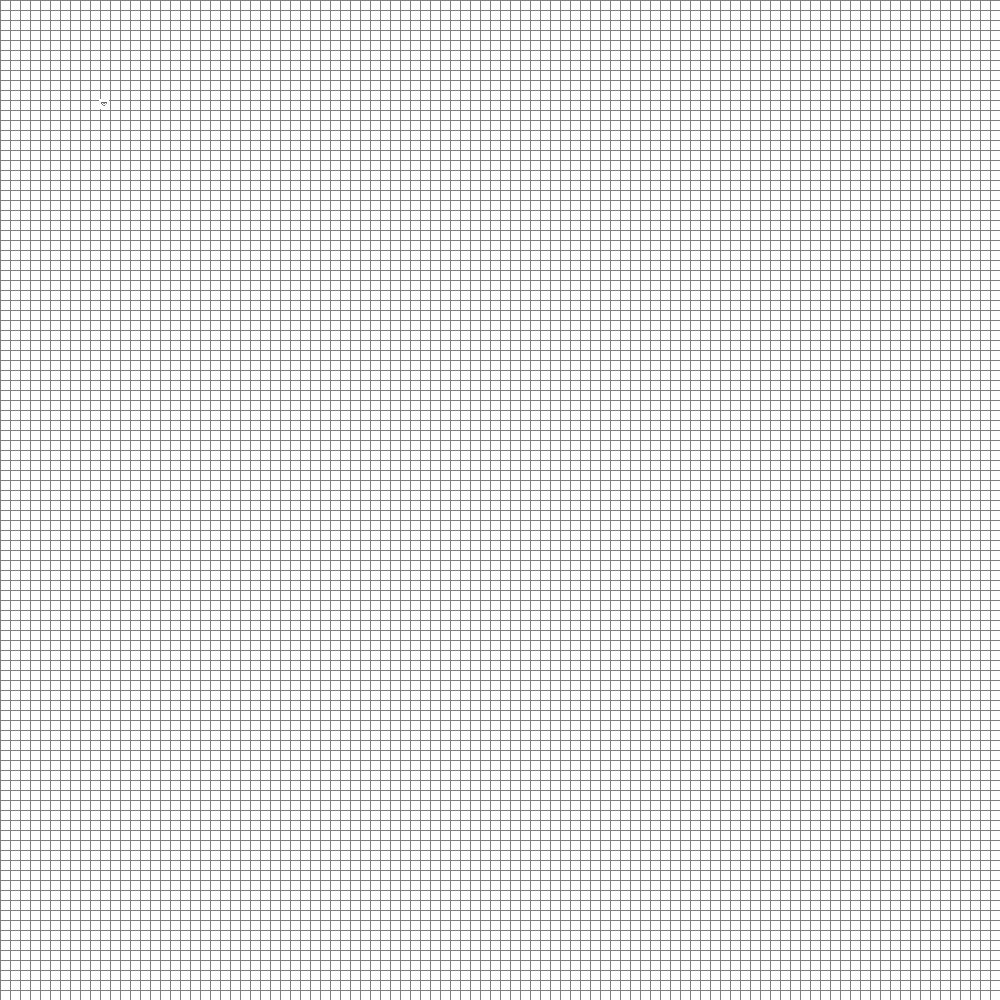

In [19]:
from PIL import Image, ImageDraw
height = 1000
width = 1000
num_cols = 100
num_rows = 100

def draw_grid(num_rows, num_cols)->Image:
  image = Image.new(mode='L', size=(height, width), color=255)
  # Draw some lines
  draw = ImageDraw.Draw(image)
  y_start = 0
  y_end = image.height
  x_start = 0
  x_end = image.width

  step_size_col = int(image.width / num_cols)
  step_size_row = int(image.height / num_rows)

  for x in range(0, image.width, step_size_col):
      line = ((x, x_start), (x, x_end))
      draw.line(line, fill=128)

  for y in range(0, image.height, step_size_row):
      line = ((y_start, y), (y_end,y))
      draw.line(line, fill=128)

  del draw
  return image

def draw_drone(background:Image, x:int, y:int)->Image:
   drone_image = Image.open("blue_drone.png")
   drone_width = int(width / num_cols)
   drone_height = int(height / num_cols)
   drone_resized = drone_image.resize((drone_width, drone_height))
   background.paste(drone_resized, (x,y))
   return background
   
grid = draw_grid(num_cols,num_rows)

for d, p in positions.items():
  state_of_play = draw_drone(grid, 99,99)
display(state_of_play)

In [ ]:
from PIL import Image, ImageDraw

image_height = 1000
image_width = 1000
num_cols = 100
num_rows = 100
col_size = int((image_width) / num_cols)
row_size = int((image_height) / num_rows)

def draw_grid()->Image:
  image = Image.new(mode='L', size=(image_height, image_width), color=255)
  # Draw some lines
  draw = ImageDraw.Draw(image)
  y_start = 0
  y_end = image.height
  x_start = 0
  x_end = image.width

  for x in range(0, image.width, col_size):
      line = ((x, x_start), (x, x_end))
      draw.line(line, fill=128)

  for y in range(0, image.height, row_size):
      line = ((y_start, y), (y_end,y))
      draw.line(line, fill=128)

  del draw
  return image

def get_position_from_grid(background:Image, grid_x:float, grid_y:float)->tuple:
      step_size_col = int(background.width / num_cols)
      step_size_row = int(background.height / num_rows)
      return(grid_x*step_size_col, grid_y*step_size_row)

def draw_drone(background:Image, grid_x:float, grid_y:float)->Image:
    drone_image = Image.open("blue_drone.png")
    drone_width = col_size
    drone_height = row_size
    drone_resized = drone_image.resize((drone_width*3, drone_height*3))
    drone_position_on_screen = get_position_from_grid(grid_x=grid_x, grid_y=grid_y)
    background.paste(drone_resized, (drone_position_on_screen, drone_position_on_screen))
    return background

# def draw_drones(background:Image, agent:str)->Image:
#   positions = get_drone_position(agent=agent, verbose=False)
#   for k, v in positions.items():
#     # print("Drawing {}: [{},{}]".format(k, v[0], v[1]))
#     background = draw_drone(background=background, grid_x=v[0], grid_y=v[1])
#   return background

def draw_drones(background:Image, positions:dict)->Image:
  for k, v in positions.items():
    draw_drone(background, v[0], v[1])
  return background

def get_connected_drones(agent:str)->list: 
    connected_agents = cyborg.environment_controller.get_connected_agents(agent=agent)
    connected_drones = []
    for a in connected_agents:
      if agent not in a:
        connected_drones.append(get_drone_name(agent=a))
    return list(set(connected_drones))

def get_drone_name(agent:str):
   # blue_agent_0
  index = agent.find("_agent_")
  # drone_3
  drone_name = "drone"+agent[index+len("_agent"):]
  return drone_name
   
def draw_connections(background:Image, agent:str):
  #  print(cyborg.environment_controller.get_connected_agents(blues[0]))
  def draw_connection(background: Image, d1:tuple, d2:tuple)->Image:
    # Draw a line between the two points
    draw = ImageDraw.Draw(background)
    draw.line(d1, d2], fill="black", width=2)
    return background
  
  connected_drones = get_connected_drones(agent)
  
  agent_drone = get_drone_name(agent)
  agent_drone_position = get_position_from_grid(background, positions[agent_drone][0], positions[agent_drone][0])
  other_drone_position = positions[connected_drones[0]]
  agent_drone_position = (0,0)
  other_drone_position = (10,10)
  print("{} ({}) is connected to {} ({})".format(agent_drone,agent_drone_position,connected_drones[0],other_drone_position))
  

  background = draw_connection(background, 
                               (agent_drone_position[0], agent_drone_position[1]),
                               (other_drone_position[0], other_drone_position[1]))
  return background
  
  # for d in connected_drones:
     
     
     
# for b in blues:

grid = draw_grid()
# connections = draw_connections(grid, blues[0])
# state_of_play = draw_drones(grid, positions)
display(draw_connections(grid, blues[0]))